# P3 : Partie cleaning des données

In [2]:
# On importe les librairies dont on aura besoin pour ce tp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, cm as cm
from sklearn import linear_model
    
# Lieu où se trouve le fichier
_FICHIER = 'C:\\Users\\Toni\\Desktop\\movie_metadata.csv'
_DOSSIERTRAVAIL = 'C:\\Users\\Toni\\python\\python\\Projet_3\\images'

In [3]:
# On charge le dataset
data = pd.read_csv(_FICHIER)

# Fonctions secondaires

Fonction qui va permettre de récupérer des stats facilement sur les données d'entrée

In [4]:
def get_stats(param):

    return {'min':param.min(),
            'max':param.max(),
            'count': param.count(),
            'mean':param.mean()
           }

Fonction qui effectue le décompte des mots séparés par des "|" dans les différentes Séries du dataset initial

In [5]:
def count_word(data, ref_col, liste):

    keyword_count = dict()

    for word in liste:
        keyword_count[word] = 0

    for liste_keywords in data[ref_col].str.split('|'):
        if isinstance(liste_keywords, float) and pd.isnull(liste_keywords):
            continue
        for word in [word for word in liste_keywords if word in liste]:
            if pd.notnull(word):
                keyword_count[word] = keyword_count[word] + 1

    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []

    for k, v in keyword_count.items():
        keyword_occurences.append([k, v])

    keyword_occurences.sort(key=lambda x: x[1], reverse=True)

    return keyword_occurences, keyword_count

Fonction d'affichage d'un histogramme des fréquences des données selectionnées

In [30]:
def afficher_plot(type_donnee, trunc_occurences):

    fichier_save = _DOSSIERTRAVAIL + '\\' + type_donnee

    words = dict()

    for word in trunc_occurences:
        words[word[0]] = word[1]

    plt.figure(figsize=(12, 8))
    y_axis = [i[1] for i in trunc_occurences]
    x_axis = [k for k, i in enumerate(trunc_occurences)]
    x_label = [i[0] for i in trunc_occurences]
    plt.xticks(rotation=90, fontsize=10)
    plt.xticks(x_axis, x_label)

    plt.yticks(fontsize=10)
    plt.ylabel("Nb. of occurences", fontsize=18, labelpad=10)

    plt.bar(x_axis, y_axis, align='center', color='b')

    plt.savefig(fichier_save, dpi=100)

    plt.title(type_donnee + " popularity", fontsize=25)
    plt.show()

Fonction qui comptabilise. Utile pour la fonction "afficher plot"

In [7]:
def comptabiliser(data, valeur_cherchee):

    # compter tous les genres différents
    listing = set()

    for word in data[valeur_cherchee].str.split('|').values:
        if isinstance(word, float):
            continue
        listing = listing.union(word)

    # compter le nombre d'occurence de ces genres
    listing_compte, dum = count_word(data, valeur_cherchee, listing)

    return listing_compte

Fonction qui permet de créer une visualisation du lien entre les variables 2 à 2

In [8]:
def correlation_matrix(data):

    # Calcul de la matrice
    corr = data.corr()
    cmap = cm.get_cmap('jet', 30)

    # Taille de la figure
    plt.figure(figsize=(10, 10))
    # Création du type d'image
    cax = plt.imshow(data.corr(), interpolation="nearest", cmap=cmap)
    plt.grid(True)

    # Libellés sur les axes
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=15)
    plt.yticks(range(len(corr.columns)), corr.columns, fontsize=15)

    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    plt.colorbar(cax, ticks=[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
    plt.show()

Fonction qui crée des histogrammes

In [25]:
def histogramme(data, colon):

    fichier_save = _DOSSIERTRAVAIL + '\\' + 'histogram_' + colon

    plt.figure(figsize=(10, 6))
    plt.xlabel('Valeurs')
    plt.ylabel('Décompte')
    titre = 'Histogramme ' + colon
    plt.title(titre)
    plt.hist(data[colon][np.isfinite(data[colon])], bins=100)
    plt.savefig(fichier_save, dpi=100)
    plt.show()

Fonction qui permet d'afficher les nuages de points

In [10]:
def scatter_plot(data, nom_colonne2, nom_colonne):

    #Log
    print("Fct scatter_plot\n")

    data = data[data[nom_colonne] <= data[nom_colonne].quantile(0.98)]
    data = data[data[nom_colonne2] <= data[nom_colonne2].quantile(0.98)]

    # Déliminations du visuel pour x
    xmax = max(data[nom_colonne])
    ymax = max(data[nom_colonne2])

    # Déliminations du visuel pour y
    xmin = min(data[nom_colonne])
    ymin = min(data[nom_colonne2])

    # création du nuage de point avec toujours la même ordonnée
    data.plot(kind="scatter", x=nom_colonne, y=nom_colonne2)

    # Affichage
    plt.grid(True)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.show()

Imputation linéaire pour les valeurs NaN pour les colonnes selectionnées

In [11]:
def input_reg_linear(data, colon_predict, colon_ref):

    # Création de la régression linéaire
    regr = linear_model.LinearRegression()
    test = data[[colon_predict, colon_ref]].dropna(how='any', axis=0)

    # Conversion en NP
    x_data = np.array(test[colon_ref])
    y_data = np.array(test[colon_predict])

    # Reshape obligatoire
    x_data = x_data.reshape(len(x_data), 1)
    y_data = y_data.reshape(len(y_data), 1)

    # On fit les données préparées
    regr.fit(x_data, y_data)

    valeurs_nulles = data[data[colon_predict].isnull() & data[colon_ref].notnull()]

    for index, row in valeurs_nulles.iterrows():
        value = float(regr.predict(row[colon_ref]))
        data.set_value(index, colon_predict, value)

# Fonction principale

In [12]:
# On charge le dataset
data = pd.read_csv(_FICHIER)

# Suppresion de doublons
data=data.drop_duplicates(subset = ['movie_title', 'actor_1_name', 'director_name'], keep='first')

# Classe et affiche des données manquantes
print("Données manquantes")
missing_data = data.isnull().sum(axis=0).reset_index()
missing_data.columns = ['column_name', 'missing_count']
missing_data['filling_factor'] = (data.shape[0]-missing_data['missing_count'])/data.shape[0]*100
missing_data.sort_values('filling_factor').reset_index(drop=True)

Données manquantes


,column_name,missing_count,filling_factor
0,gross,863,82.455784
1,budget,485,90.140272
2,aspect_ratio,326,93.372637
3,content_rating,301,93.880870
4,plot_keywords,152,96.909941
5,title_year,106,97.845090
6,director_name,102,97.926408
7,director_facebook_likes,102,97.926408
8,num_critic_for_reviews,49,99.003863
9,actor_3_facebook_likes,23,99.532425


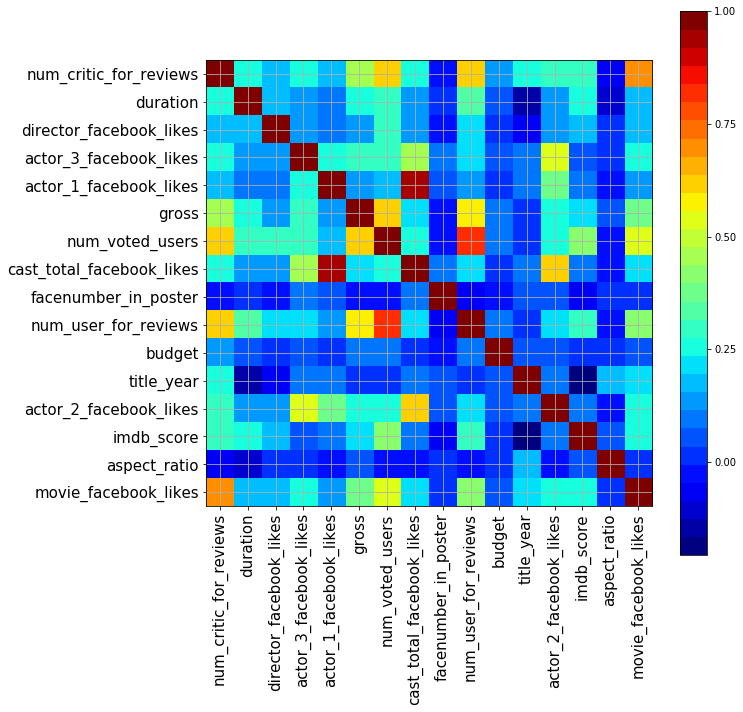

In [13]:
# Matrice de correlation
correlation_matrix(data)

# On peut en conclure qu'il y a une corrélation forte entre "gross" et "num_voted_users"

In [14]:
data_reg = data.copy()

# Masque pour supprimer les valeurs NaN des deux colonnes en préparation des régressions linéaires
mask_colon1 = np.isfinite(data_reg['gross'])

colon1 = 'gross'

for colon2 in data:
    if (data_reg[colon2].dtype == 'float' or data_reg[colon2].dtype == 'int64') and colon2 != colon1:

        # On utilise le masque1 pour 'gross' et le masque2 pour la deuxième donnée
        mask_colon2 = np.isfinite(data_reg[colon2])
        mask = mask_colon1 & mask_colon2

        # Calcul d'une regression linéaire
        regr = linear_model.LinearRegression()

        # Reshape
        data_x = data_reg[colon1].values.reshape(-1, 1)
        data_y = data_reg[colon2].values.reshape(-1, 1)

        # Fit
        regr.fit(data_x[mask], data_y[mask])

        # Affichage de la variances : On doit être le plus proche possible de 1
        print('Regression sur :', colon1, colon2)
        print('Score : %.2f' % np.corrcoef(data_reg[colon1][mask], data_reg[colon2][mask])[1, 0])
        print('R2    : %.2f \n' % regr.score(data_x[mask], data_y[mask]))


Regression sur : gross num_critic_for_reviews
Score : 0.47
R2    : 0.22 

Regression sur : gross duration
Score : 0.24
R2    : 0.06 

Regression sur : gross director_facebook_likes
Score : 0.14
R2    : 0.02 

Regression sur : gross actor_3_facebook_likes
Score : 0.29
R2    : 0.08 

Regression sur : gross actor_1_facebook_likes
Score : 0.15
R2    : 0.02 

Regression sur : gross num_voted_users
Score : 0.64
R2    : 0.40 

Regression sur : gross cast_total_facebook_likes
Score : 0.24
R2    : 0.06 

Regression sur : gross facenumber_in_poster
Score : -0.03
R2    : 0.00 

Regression sur : gross num_user_for_reviews
Score : 0.56
R2    : 0.31 

Regression sur : gross budget
Score : 0.10
R2    : 0.01 

Regression sur : gross title_year
Score : 0.02
R2    : 0.00 

Regression sur : gross actor_2_facebook_likes
Score : 0.25
R2    : 0.06 

Regression sur : gross imdb_score
Score : 0.20
R2    : 0.04 

Regression sur : gross aspect_ratio
Score : 0.07
R2    : 0.00 

Regression sur : gross movie_faceb

Affichage des nuages de points

Fct scatter_plot



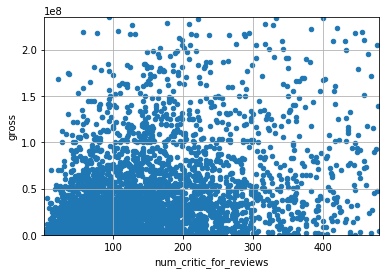

Fct scatter_plot



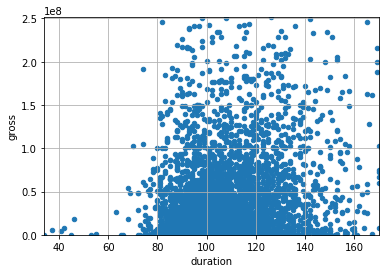

Fct scatter_plot



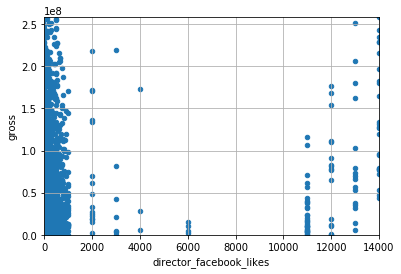

Fct scatter_plot



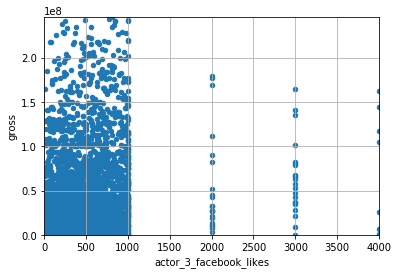

Fct scatter_plot



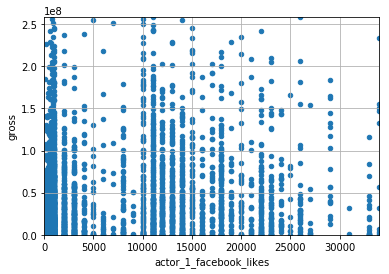

Fct scatter_plot



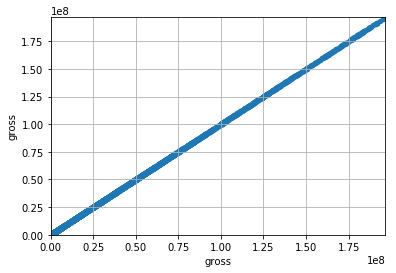

Fct scatter_plot



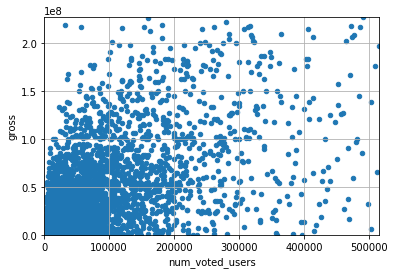

Fct scatter_plot



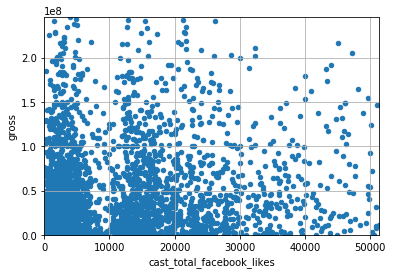

Fct scatter_plot



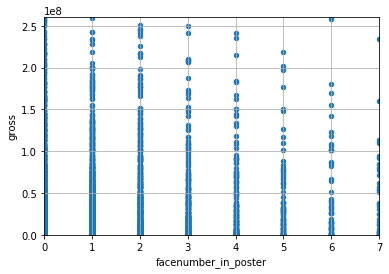

Fct scatter_plot



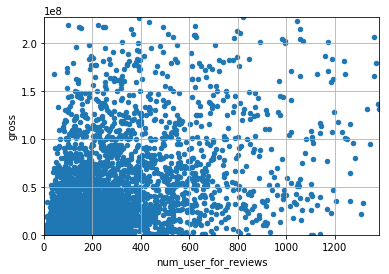

Fct scatter_plot



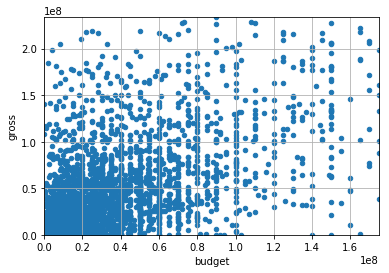

Fct scatter_plot



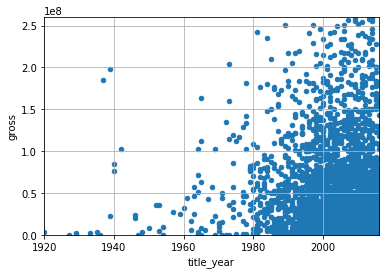

Fct scatter_plot



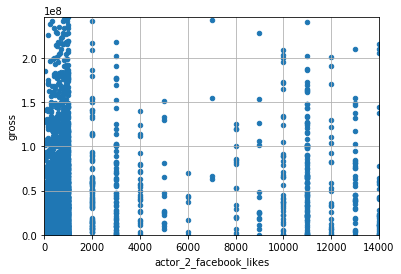

Fct scatter_plot



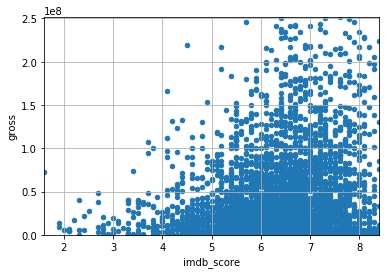

Fct scatter_plot



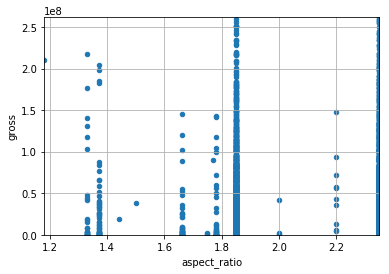

Fct scatter_plot



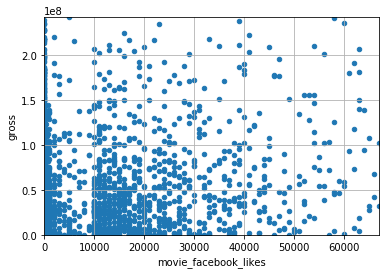

In [16]:
for nom_colonne in data:
    if data[nom_colonne].dtype == 'float' or data[nom_colonne].dtype == 'int64':
        scatter_plot(data, 'gross', nom_colonne)

Création des histogrammes

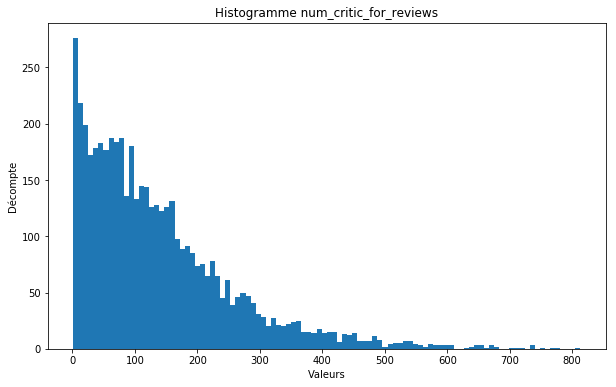

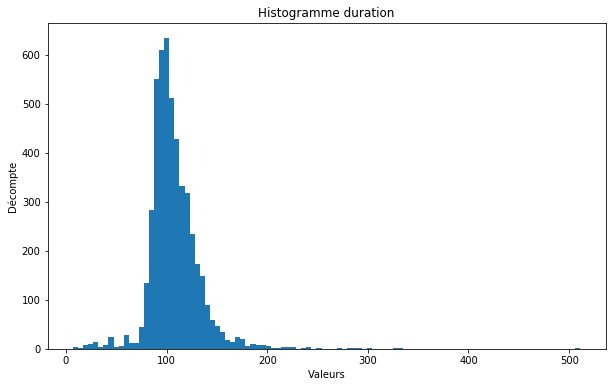

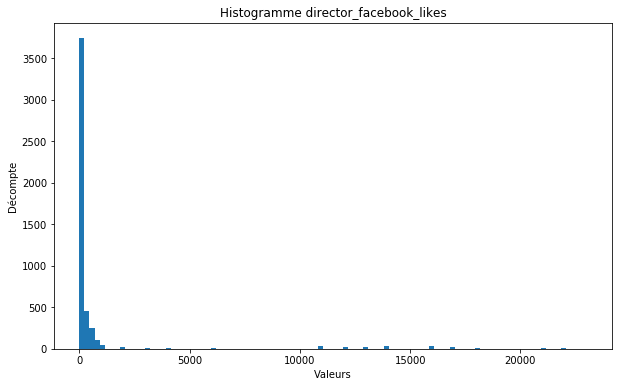

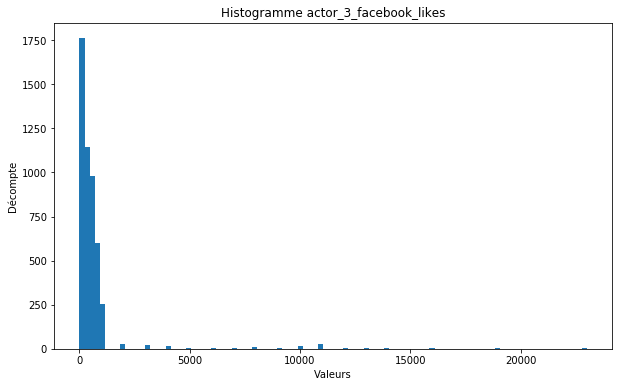

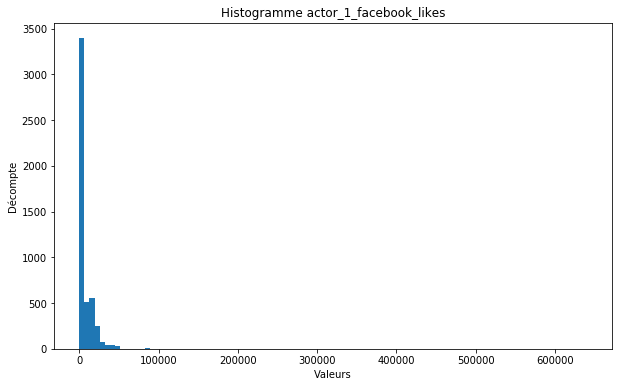

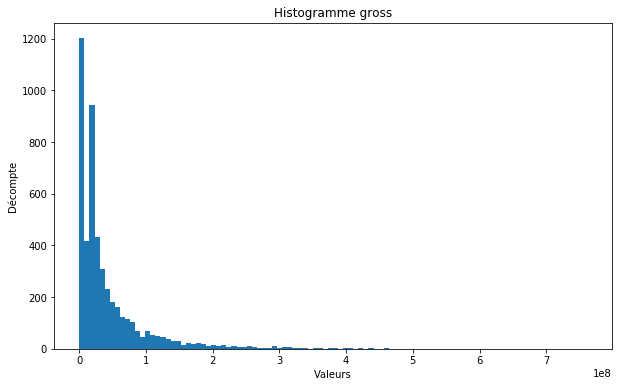

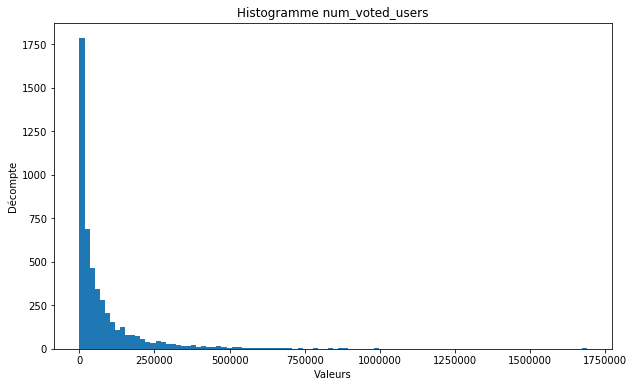

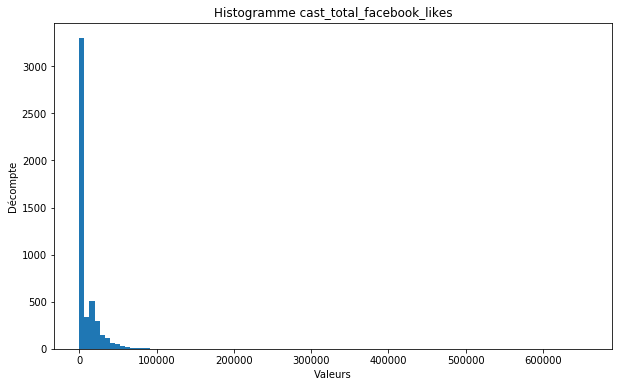

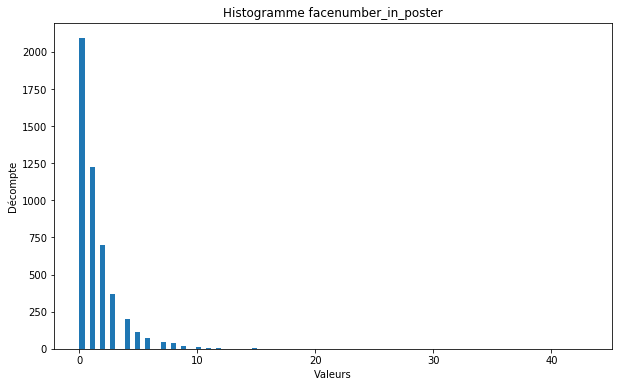

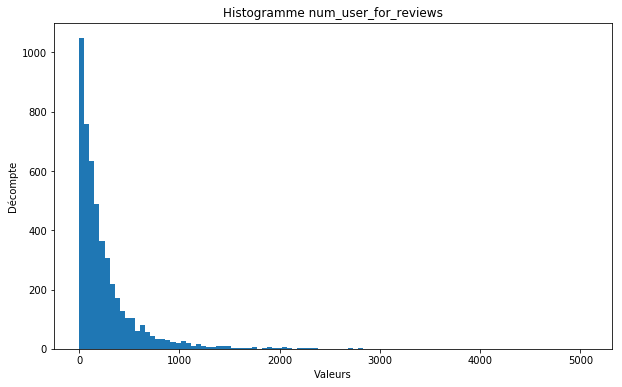

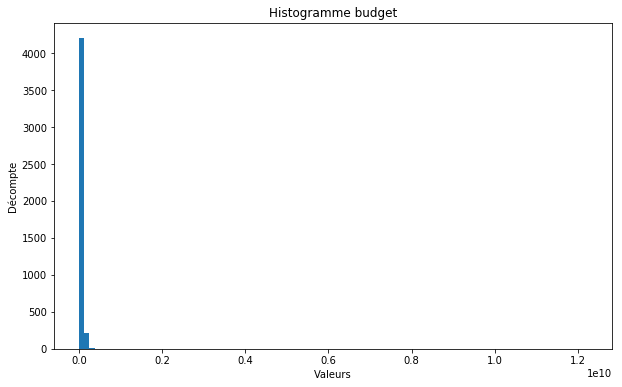

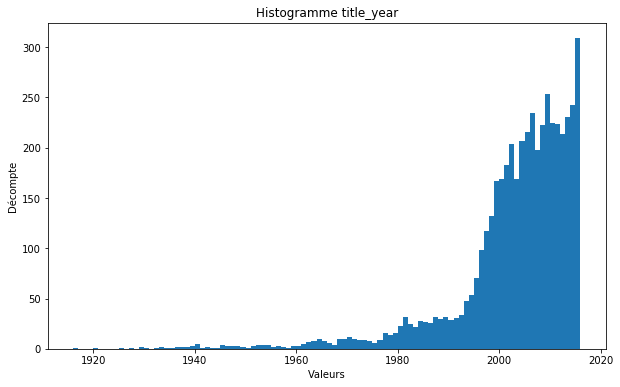

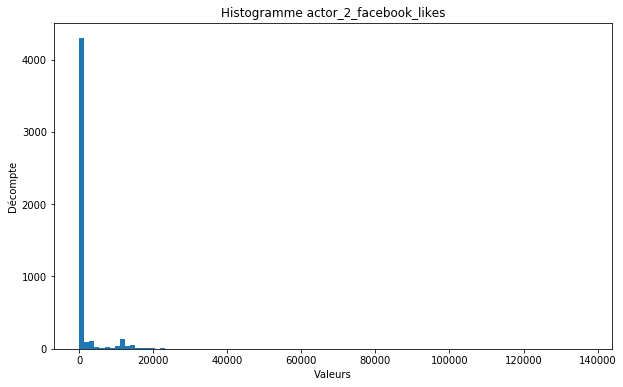

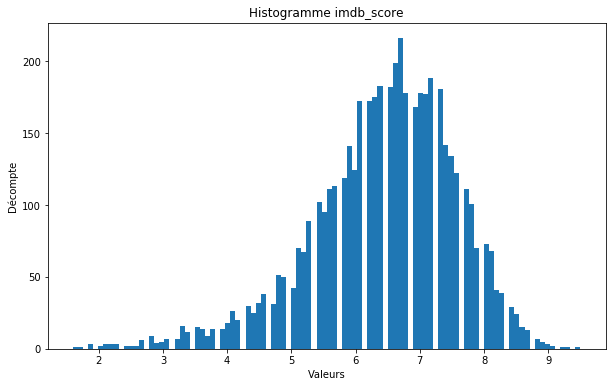

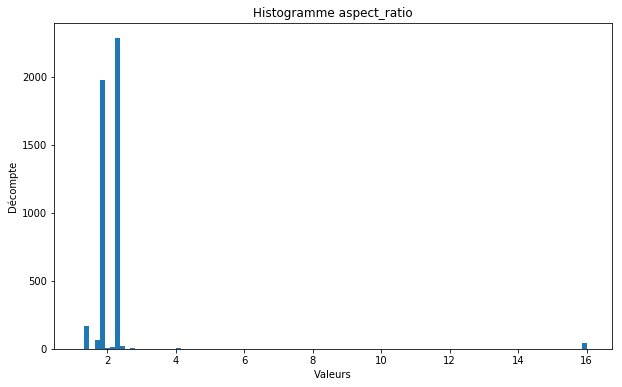

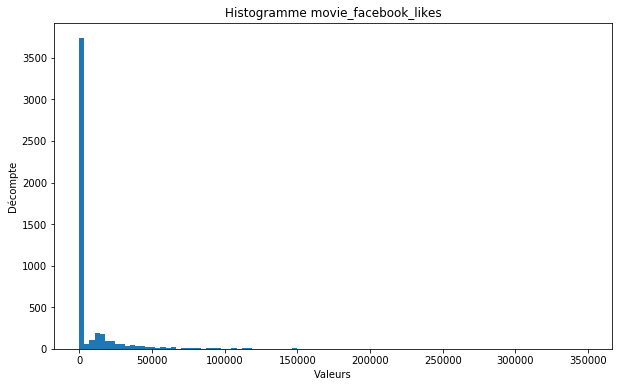

In [26]:
for nom_colonne in data:
    if data[nom_colonne].dtype == 'float' or data[nom_colonne].dtype == 'int64':
        histogramme(data, nom_colonne)

Homogénéisation "manuelle" des ratings en 5 classes américaines connues.

In [18]:
data['content_rating'] = data['content_rating'].replace('Unrated', 'Not Rated')
data['content_rating'] = data['content_rating'].replace('Approved', 'Passed')
data['content_rating'] = data['content_rating'].replace('TV-14', 'R')
data['content_rating'] = data['content_rating'].replace('TV-MA', 'NC-17')
data['content_rating'] = data['content_rating'].replace('TV-PG', 'PG-13')
data['content_rating'] = data['content_rating'].replace('GP', 'PG')
data['content_rating'] = data['content_rating'].replace('X', 'NC-17')
data['content_rating'] = data['content_rating'].replace('M', 'R')
data['content_rating'] = data['content_rating'].replace('TV-Y', 'G')
data['content_rating'] = data['content_rating'].replace('TV-Y7', 'G')
data['content_rating'] = data['content_rating'].replace('TV-G', 'PG')
data['content_rating'] = data['content_rating'].replace('Passed', 'G')

data['content_rating'] = data['content_rating'].replace('G', 'G-')
data['content_rating'] = data['content_rating'].replace('PG-13', 'PG13')
data['content_rating'] = data['content_rating'].replace('PG', 'P-G')
data['content_rating'] = data['content_rating'].replace('R', 'Rated-R')

Recensement des données que l'on a. On va créer des graphiques en barre pour trouver l'occurence de ces données

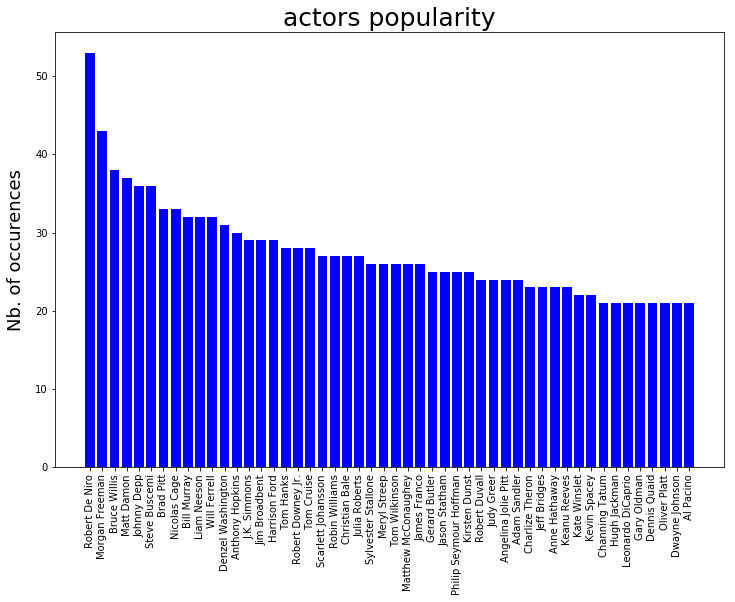

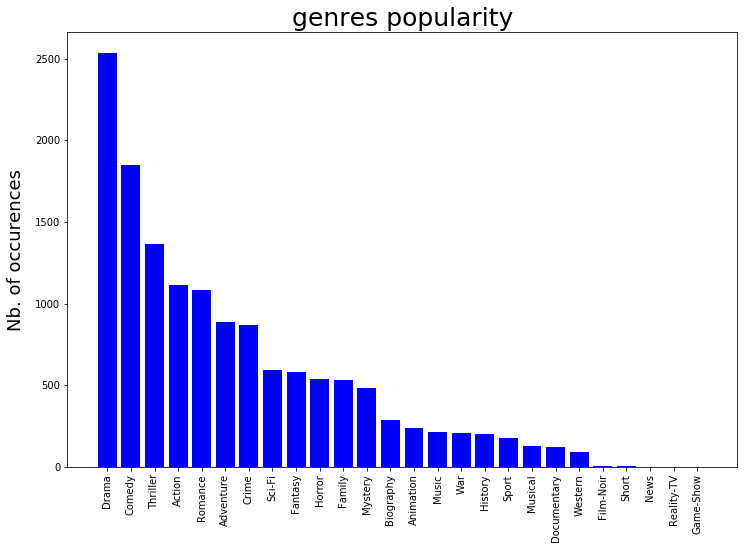

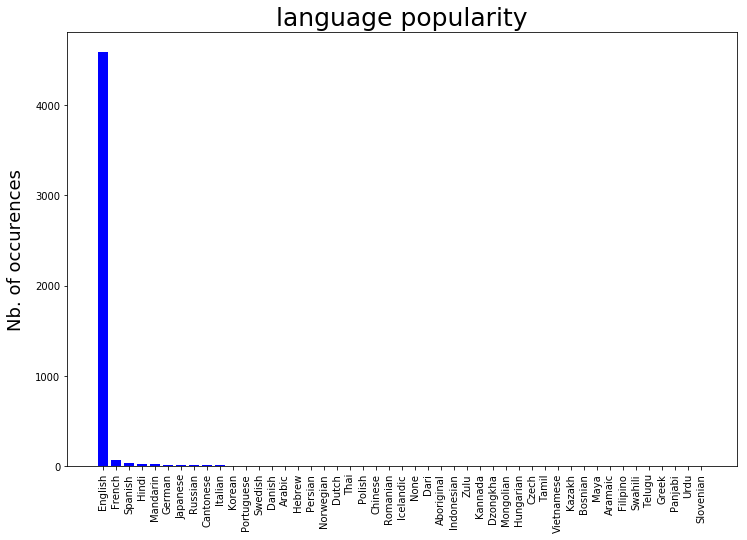

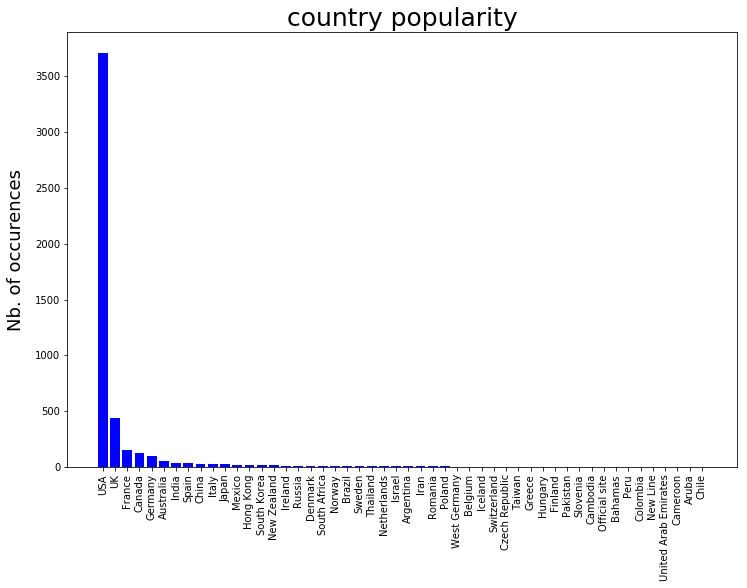

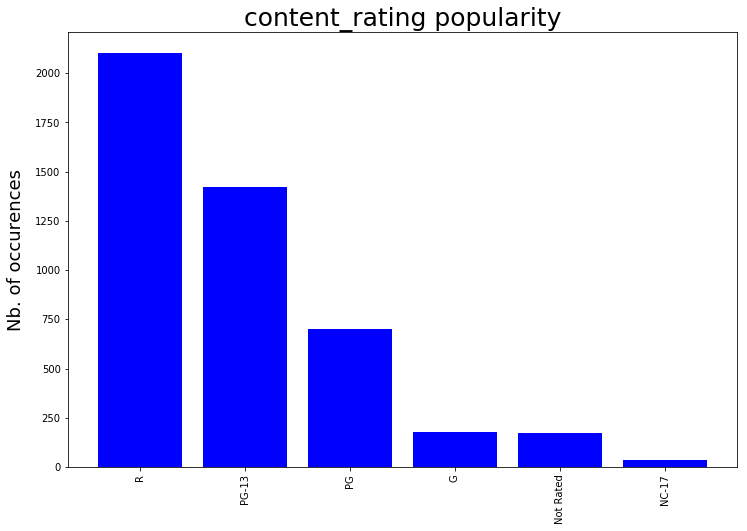

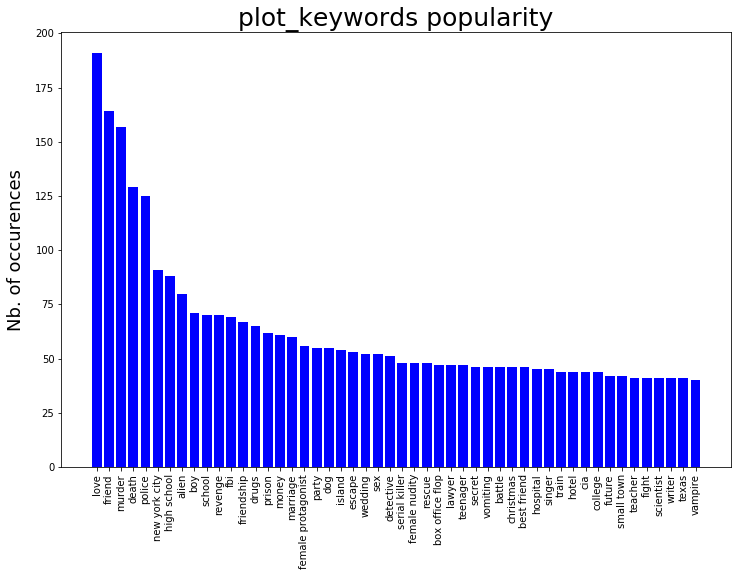

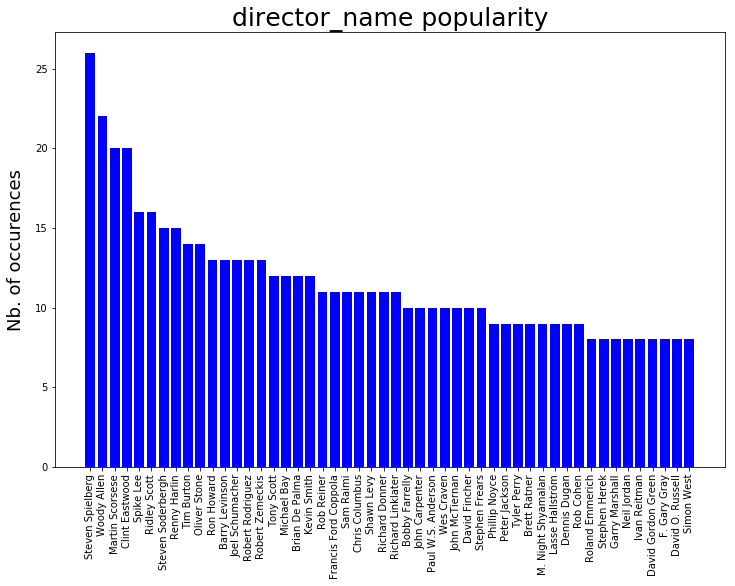

In [31]:
## Cas particulier des noms d'acteurs
# Création de la database avec tous les noms d'acteurs car ils sont sur 3 colonnes
db_names = []
db_names.extend(data['actor_1_name'])
db_names.extend(data['actor_2_name'])
db_names.extend(data['actor_3_name'])
data_names = pd.DataFrame(db_names, columns=['name'])

# compter tous les acteurs de films
actors_list = comptabiliser(data_names, 'name')
afficher_plot('actors', actors_list[0:50])

## Pour tous les autres
list_a_afficher = ['genres', 'language', 'country', 'content_rating', 'plot_keywords', 'director_name']

for name in list_a_afficher:
    res = comptabiliser(data, name)
    afficher_plot(name, res[0:50])

Prédiction de la valeur des 'gross' manquantes

In [20]:
colon_predict = 'gross'
colon_ref = 'num_voted_users'

input_reg_linear(data, colon_predict, colon_ref)

Exportation

In [22]:
data.to_csv('C:\\Users\\Toni\\Desktop\\pas_synchro\\p3_bdd_clean_v2.csv')